# PaddleOCR Multilingual Model Training Tutorial

PaddleOCR provides 80 language models, but still can not cover all. the released model can achieve a better result when you fine-tune with your own recognition data. If you have the following questions:

- Bad efforts when testing the original recognition model
- Lack of data and confusion about the training process
- Don't know how to replace or modify the dictionary

this tutorial will help you learn how to synthesize recognition images to train a custom recognition model, specifically, including:
- Corpus synthesis improves a certain category of recognition results, take Thai for example
- Use your own dictionary and corpus to train a model like the digital-only model, multilingual model, etc.
- A step-by-step training guide including how to configure training parameters via `.yml` configuration file
- Export the trained model to the inference model


<img src='https://user-images.githubusercontent.com/50011306/184822349-c214e8b7-90f5-4bab-9833-978b5055af04.png' width="600" heith="600">

Any question about the tutorial can be discussed in the [PaddleOCR's GitHub Discussion](https://github.com/PaddlePaddle/PaddleOCR/discussions)

## Environment preparation

In [ ]:
# install paddlepaddle and paddleocr whl package
# !pip install -U pip
!pip install paddlepaddle paddleocr
!git clone https://github.com/PaddlePaddle/PaddleOCR

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112.5 MB 50 kB/s 
     |████████████████████████████████| 334 kB 56.5 MB/s 
     |████████████████████████████████| 394 kB 58.5 MB/s 
     |████████████████████████████████| 604 kB 55.3 MB/s 
     |████████████████████████████████| 2.8 MB 41.8 MB/s 
     |████████████████████████████████| 55.7 MB 1.1 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 399 kB 65.0 MB/s 
     |████████████████████████████████| 204 kB 74.9 MB/s 
     |████████████████████████████████| 2.3 MB 46.3 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149870 sha256=13e0c0f3322ef2cbbe613bb8949dcf246b2ddfecfc4c8eb008a2d8c68903b3c9
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Lev

In [ ]:
# data synthesis tool
!git clone https://github.com/tink2123/text_renderer.git

Cloning into 'text_renderer'...
remote: Enumerating objects: 627, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 627 (delta 12), reused 41 (delta 11), pack-reused 580
Receiving objects: 100% (627/627), 13.75 MiB | 18.03 MiB/s, done.
Resolving deltas: 100% (318/318), done.


### Install third-party requirements

In [ ]:
!cd PaddleOCR && pip install -r requirements.txt

In [ ]:
!pip install -r ./text_renderer/requirements.txt

### Quick use

First we show the use of the paddleocr WHL package. If you want to learn all about how to use the WHL package please look at [this tutorial](https://colab.research.google.com/drive/1_GpuvV0eO10TeTX1aCbVFc3aWK5cVcBC?usp=sharing).

In [ ]:
!paddleocr --image_dir /your/image/path --lang=en

## Data preparation

Training a recognition model always need tremendous recognition images, like 0.1 to 1 million. In addition to existing datasets, it is very difficult to obtain so much real data in general, so synthetic data often plays an important role in expanding the amount of data. On the other hand, if there is only synthetic data, the generalization ability of the model may not be strong enough. In the actual training process, it is often a better method to sample real data and synthetic data in a certain proportion.

### Real data annotation

We recommend using [PPOCRLabel](https://github.com/PaddlePaddle/PaddleOCR/tree/release/2.5/PPOCRLabel) as the annotation tool for OCR task, because it has a build-in PP-OCR model to automatically detect and re-recognize data, which can impove the efficiency more than 50%.

For more informaiton, please read the [README of PPOCRLabel](https://github.com/PaddlePaddle/PaddleOCR/tree/release/2.5/PPOCRLabel)

<img src='https://github.com/PaddlePaddle/PaddleOCR/raw/release/2.5/PPOCRLabel/data/gif/steps_en.gif' width="600" heith="600">

### Synthetic data

Data synthesis tools：

Synthesizing recognition images requires five elements: dictionary, corpus, font, background images, and a text images generator tool (recommend [text_renderer](https://github.com/Sanster/text_renderer), suitable for multiple languages). then control the final effects via configuration such as spacing, horizontal and vertical, bending, etc., so that the synthesized image can be approximated to the real image.

Next we describe how to obtain these elements in turn.

#### Dictionary and corpus

The dictionary corresponds to the text information that the model needs to recognize, in another word, all the text that needs to be recognized should appear in the dictionary. The corpus is the words and sentences needed to generate text images, and the synthesis tool will synthesize text images according to the corpus.

Both of the dictionary files and the corpus files are .txt format in PaddleOCR.

For example a partial Thai dictionary is like:
```
ก
ข
ค
ฆ
ง
จ
ฉ
ช
ซ
ฌ
ญ
ฎ
ฏ
```

a partial Thai corpus is like:

```
โต้ทีดีอาร์ไอ
แต่คำตอบที่ว่า
ทุกกรณีปัญหา
นักรักชาติ
“นโยบายสามหก”
Islington
อะซีม
```

There are three ways to obtain dictionary and corpus

- Download from PaddleOCR github repository

	PaddleOCR has released a series dictionary in [the github repo](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.5/ppocr/utils/dict), which had been used to train the PP-OCR mutilingual models (you can find the trained model [here](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.5/doc/doc_en/models_list_en.md#23-multilingual-recognition-modelupdating)). At the same time, many developers have contributed dictionaries and corpus of some languages through PRs or comments under [the Multilingual OCR Development Plan](https://github.com/PaddlePaddle/PaddleOCR/issues/1048) issue.

- Custom Dictionary or cropus

	The above dictionaries are often used in generic scenarios, while in other scenarios the required characters are specific or not all the characters in the generic dictionary are needed, so the content of the dictionary can be customized according to the scenario. For expample, if you only want to recognize digital, your dictionary only contains 0-9.

	If you want to improve certain effects in a targeted manner, such as spaces, special symbols, punctuation, etc., you can add more of this information when you construct corpus

- Get dictionary through corpus

	The third method is to prepare a dictionary based on the corpus. This method is suitable for preparing the corpus content first, and traversing the corpus content through an algorithm to generate a dictionary containing all the words in the corpus.




#### Fonts and background

When the model recognizes some unseen font forms (like Dot matrix font, digital tube font), bad results may occur, so we need to synthesize data of similar fonts.

You can find different types of fonts in the fonts webside.

The background of the synthesize data should be similar with the reall data. If you train a model for a specific scene, you can directly snap out the background image from the real data. For example, in the PCB scene, the images are all in green, which requires a similar green image as the background.

If the background in the scene is not uniform, you can also use the data in ImageNet as the background image

<img src='https://github.com/tink2123/text_renderer/blob/master/data/bg/%E8%83%8C%E6%99%AF.png?raw=true' width="200" heith="200">


#### Start synthesis

The way to use `text_renderer` is really simple, only need to spicify `fonts_list`, `chars_file` to the path of your fonts and dictionary



Place the prepared corpus, dictionary, and background image in the text_renderer/data directory, and modify the default configuration, taking the English data as an example.
1. prepare `n` corpus listed in [thai_movies.txt](/content/text_renderer/data/en_corpus/en_movies.txt)
2. If you want to enhance the data richness, prepare some background images to be placed under the `data/bg path`, in this case 5 imagenet are provided.
3. Modify the default parameters in `text_renderer/parse_args.py`: `--chars_file`, `--fonts_list`, `--corpus_dir`, `--corpus_mode`

Start the data synthesis script

In [ ]:
!cd text_renderer && python main.py --num_img=10

Total fonts num: 1
Background num: 6
Loading corpus from: ./data/en_corpus
Load corpus: ./data/en_corpus/en_movies.txt
Total lines: 25
Generate text images in ./output/default
10/10 100%
Finish generate data: 1.224 s


The synthesis data is stored in the `output/default` directory.




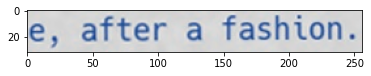

In [ ]:
import cv2
import matplotlib.pyplot as plt

raw_img = cv2.imread("/content/text_renderer/output/default/00000000.jpg")
plt.imshow(raw_img)

Also, the ground truth information that can be used to train PaddleOCR is stored in `output/default/label.txt`

```
default/00000000.jpg	(พลังน้ำ)
default/00000001.jpg	โต้ทีดีอาร์ไอ
default/00000002.jpg	แต่คำตอบที่ว่า
default/00000003.jpg	ทุกกรณีปัญหา
default/00000004.jpg	นักรักชาติ
default/00000005.jpg	“นโยบายสามหก”
default/00000006.jpg	และคนมีเหตุมีผล
...
```

### Thai language data

As the synthesis process is long, we provide an already synthesized Thai language dataset.

Click the [link](https://drive.google.com/file/d/1ZJIdL4n9OTiKLj4SDSEQjT_3i6B14998/view?usp=sharing) to save the synthesis Thai language data to your google drive, and then open file from your drive, unzip the `th_img.tar` to the PaddleOCR folder.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
!mkdir /content/PaddleOCR/train_data
!cp /gdrive/MyDrive/th_img.tar /content/PaddleOCR/train_data/

mkdir: cannot create directory ‘/content/PaddleOCR/train_data’: File exists


In [ ]:
!cd /content/PaddleOCR/train_data/ && tar -xf th_img.tar
%cd /content/PaddleOCR

The required annotation format of PaddleOCR is use a `\t` to split the iamge path and image label. If you use other methods to split, it will cause training error

```
" Image file name                       Image annotation "
th_img/0/ILSVRC2012_val_00019591_5.jpg  ทุกกรณีปัญหา
th_img/0/ILSVRC2012_val_00010000_5.jpg  ทุกกรณีปัญหา
th_img/0/ILSVRC2012_val_00012707_5.jpg  ทุกกรณีปัญหา
th_img/0/ILSVRC2012_val_00017283_5.jpg  ทุกกรณีปัญหา
th_img/0/ILSVRC2012_val_00012583_5.jpg  ทุกกรณีปัญหา
th_img/0/ILSVRC2012_val_00015817_6.jpg  นักรักชาติ
th_img/0/ILSVRC2012_val_00018484_6.jpg  นักรักชาติ
th_img/0/ILSVRC2012_val_00010596_6.jpg  นักรักชาติ
th_img/0/ILSVRC2012_val_00013689_6.jpg  นักรักชาติ
th_img/0/ILSVRC2012_val_00013117_6.jpg  นักรักชาติ

...
```

### Dataset structure

When you use your own data for training, please refer to the following to organize the file structure.

- Training set

    It is recommended to put the training images in the same folder, and use a txt file ( like `rec_gt_train.txt`) to store the image path and label. The format of `rec_gt_train.txt` is as above. The contents of the txt file are as follows:

    The final training set should have the following file structure:

    ```
    |-train_data
    |-rec
        |- rec_gt_train.txt
        |- train
            |- word_001.png
            |- word_002.jpg
            |- word_003.jpg
            | ...
    ```

- Test set

    Similar to the training set, the test set also needs to be provided a folder containing all images (test) and a rec_gt_test.txt. The structure of the test set is as follows:

    ```
    |-train_data
    |-rec
        |-ic15_data
            |- rec_gt_test.txt
            |- test
                |- word_001.jpg
                |- word_002.jpg
                |- word_003.jpg
                | ...
    ```


## Model training and evaluation

PaddleOCR passes in the training parameters in the form of a configuration file (including model structure, training configuration etc.), The following is a typical configuration file form.

We add some comments above some important parameters below, you can find more configs in `/config/`

If you need to add a new configuration file, please refer to the following example to modify **`character_dict_path`** and **`dataset`**

```
Global:
  use_gpu: true
  epoch_num: 20
  ...
  save_model_dir: ./output/thai
  save_epoch_step: 3
  eval_batch_step: [0, 2000]
  ...
# Add a custom dictionary, such as modify the dictionary, please point the path to the new dictionary
  character_dict_path: train_data/th_img/th_dict.txt
  ...
# Whether to recognize spaces
  use_space_char: true
  ...

Optimizer:
  ...
  # Add learning rate decay strategy
  lr:
    name: Cosine
    learning_rate: 0.001

Architecture:
  ...
Loss:
  ...
PostProcess:  
  ...
Metric:
  ...

Train:
  dataset:
    dataset:
    # Type of dataset，we support LMDBDataSet and SimpleDataSet
    name: SimpleDataSet
    # Path of dataset
    data_dir: ./train_data/
    # Path of train list
    label_file_list: ["./train_data/th_img/train_list.txt"]
    transforms:
      ...
      - RecResizeImg:
          # Modify image_shape to fit long text
          image_shape: [3, 48, 320]
      ...
  loader:
    ...
    # Train batch_size for Single card
    batch_size_per_card: 256
    ...

Eval:
  dataset:
    # Type of dataset，we support LMDBDataSet and SimpleDataSet
    name: SimpleDataSet
    # Path of dataset
    data_dir: ./train_data
    # Path of eval list
    label_file_list: ["./train_data/th_img/train_list.txt"]
    transforms:
      ...
      - RecResizeImg:
          # Modify image_shape to fit long text
          image_shape: [3, 48, 320]
      ...
  loader:
    # Eval batch_size for Single card
    batch_size_per_card: 256
    ...

```

### Training

Because we specify many parameters through the configuration file, the command to start a model training task is simple, just specify the path of the config file through `-c`

```
!python3 tools/train.py -c configs/rec/PP-OCRv3/multi_language/latin_PP-OCRv3_rec.yml
```

PaddleOCR provides single-GPU and multi-GPU training methods. When the amount of data is large, we recommend using multi-GPU mode as the following command:

```
# specify the number of GPUs through --gpus
python3 -m paddle.distributed.launch --gpus '0,1,2,3'  tools/train.py -c configs/rec/PP-OCRv3/en_PP-OCRv3_rec.yml -o Global.pretrained_model=en_PP-OCRv3_rec_train/best_accuracy
```

Here, since the multi-GPU mode can not be used for everyone on colab, we still use a single CPU to start the basic training.

> As the size of the dataset we provided is not enough to train a good Thai language model, we recommend you synthesize or add more data.


In [ ]:
!python3 tools/train.py -c train_data/th_img/thai_PP-OCRv3_rec.yml -o Global.use_gpu=False

[2022/08/18 12:01:25] ppocr INFO: Architecture : 
[2022/08/18 12:01:25] ppocr INFO:     Backbone : 
[2022/08/18 12:01:25] ppocr INFO:         last_conv_stride : [1, 2]
[2022/08/18 12:01:25] ppocr INFO:         last_pool_type : avg
[2022/08/18 12:01:25] ppocr INFO:         name : MobileNetV1Enhance
[2022/08/18 12:01:25] ppocr INFO:         scale : 0.5
[2022/08/18 12:01:25] ppocr INFO:     Head : 
[2022/08/18 12:01:25] ppocr INFO:         head_list : 
[2022/08/18 12:01:25] ppocr INFO:             CTCHead : 
[2022/08/18 12:01:25] ppocr INFO:                 Head : 
[2022/08/18 12:01:25] ppocr INFO:                     fc_decay : 1e-05
[2022/08/18 12:01:25] ppocr INFO:                 Neck : 
[2022/08/18 12:01:25] ppocr INFO:                     depth : 2
[2022/08/18 12:01:25] ppocr INFO:                     dims : 64
[2022/08/18 12:01:25] ppocr INFO:                     hidden_dims : 120
[2022/08/18 12:01:25] ppocr INFO:                     name : svtr
[2022/08/18 12:01:25] ppocr INFO:   

If you are familiar with continue training, training with new backbone, mixed precision training, training with knowledge distillation, you can more usages in [this document](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.5/doc/doc_en/recognition_en.md)

### Evaluation

The model parameters during training are saved in the `Global.save_model_dir` directory by default. When evaluating indicators, you need to set `Global.checkpoints` to point to the saved parameter file. The evaluation dataset can be set by modifying the `Eval.dataset.label_file_list` field in the `configs/rec/PP-OCRv3/{your/config/file}.yml` file.

In [ ]:
!python3 tools/eval.py -c train_data/th_img/thai_PP-OCRv3_rec.yml -o Global.checkpoints=./output/thai/best_accuracy

## Inference





In [ ]:
!python3 tools/infer_rec.py -c train_data/th_img/thai_PP-OCRv3_rec.yml -o Global.checkpoints=./output/thai/best_accuracy  Global.infer_img=./train_data/th_img/0/ILSVRC2012_val_00019591_5.jpg